## Preparing the Shanghai Dataset for Deep Learning

We must convert the target data file format from GeoJSON into a raster format. We do this with the help of scikit-image's draw function and parsing OSM json, and no projective geometry (fortunately!!).

In [1]:
import gdal
import ogr
import numpy as np
import matplotlib.pyplot as plt
import os, sys, json
from skimage.draw import polygon
from tqdm import tqdm
import georaster
from nbutils import plot_poly

In [2]:
basedir = '/datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/'
names = os.listdir(basedir)

size = 650
source_ds = ogr.Open(basedir+names[0])
source_layer = source_ds.GetLayer()
x_min, x_max, y_min, y_max = source_layer.GetExtent()
xrng = x_max - x_min
yrng = y_max - y_min

imgdir = '/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/'
to_imgnm = lambda x: x.replace("geojson","tif").replace("buildings", "RGB-PanSharpen")
print(to_imgnm(imgdir+names[0]))
tiff = georaster.MultiBandRaster(imgdir+to_imgnm(names[0]))

names[0], to_imgnm(names[0])

/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_4_Shanghai_img2961.tif


('buildings_AOI_4_Shanghai_img2961.geojson',
 'RGB-PanSharpen_AOI_4_Shanghai_img2961.tif')

In [14]:
def send2raster(raster, geom_coords, imgtiff, val=1):
    coords = np.array(geom_coords).squeeze()
    assert len(coords.shape)==2, "Coords.shape is off, coords = {}".format(coords.shape)
    coords = coords[:,:-1] # last column is all 0s
    xs, ys = imgtiff.coord_to_px(coords[:,0], coords[:,1], latlon=True)
    row, col = tune_coords(*polygon(xs, ys))
    raster[row, col] = val
    return tune_coords(xs, ys)

def tune_coords(xs, ys):
    """just transposes"""
    return ys, xs

messed_up = []
def create_raster(geojson, imgtiff, size=650):
    """Rasterizes a geojson file by using the coordinate system of the 
    corresponding GTiff"""
    with open(geojson,'r') as f:
        geo_info = json.load(f)

    raster = np.zeros((size, size))
    polys = []
    for i, bldg in enumerate(geo_info['features']):
        try:
            if bldg['geometry']['type'] == 'Polygon':
                xs, ys = send2raster(raster, bldg['geometry']['coordinates'], imgtiff)
                polys.append(np.vstack((xs, ys)).T)
            elif bldg['geometry']['type'] == 'MultiPolygon':
                for mat in bldg['geometry']['coordinates']:
                    xs, ys = send2raster(raster, mat, imgtiff)
                    polys.append(np.vstack((xs, ys)).T)
            else:
                raise ValueError('Unrecognized geometry type: {}'.format(bldg['geometry']['type']))
        except AssertionError as e:
            print("Assertion Error on file: {}".format(geojson))
            print(f"{bldg['geometry']['type']}")
            messed_up.append(geojson)
            print(e)
    return raster, polys

In [15]:
fn = np.random.choice(names)
geojson = basedir + fn
im = imgdir + to_imgnm(fn)
tiff = georaster.MultiBandRaster(im)
raster, polys = create_raster(geojson, tiff)

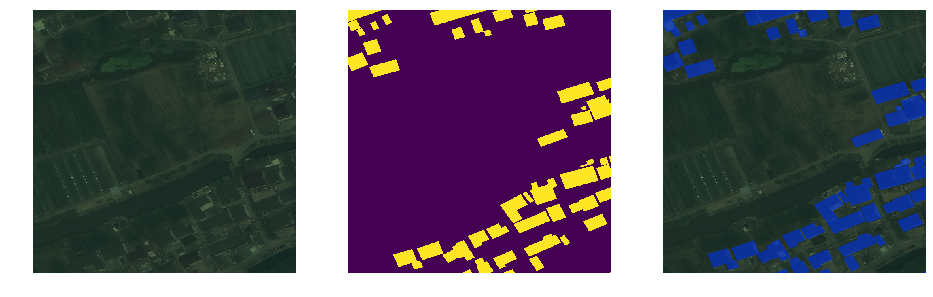

In [16]:
fig, axs = plt.subplots(figsize=(16, 12), ncols=3)
left, mid, right = axs
for a in axs.flatten():
    a.axis("off")
left.imshow(tiff.r / 2048)
mid.imshow(raster)
right.imshow(tiff.r / 2048)
plot_poly(polys, right, lambda Xpixels, Ypixels: tune_coords(Xpixels, Ypixels), (0, 0.2, 0.9, 0.6))

Save the ground truth segmentation maps in ../landuse/Shanghai-Segs

This saves the rasterized building segmentation polygons as a numpy array, and saves to memory in the same location that the Shanghai images are from.

In [17]:
destdir='../../landuse/Shanghai-Segs/'
for n in names:
    fn = np.random.choice(names)
    geojson = basedir + fn
    im = imgdir + to_imgnm(fn)
    tiff = georaster.MultiBandRaster(im)
    raster, polys = create_raster(geojson, tiff)
    np.save(destdir+fn.replace('tif', 'npy'), raster)

Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4596.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4596.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5931.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3476.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4763.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img135.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5330.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5263.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3954.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5001.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2833.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3474.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3476.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3649.geojson
Polygon
Coords.shape is off, coords = (3,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4213.geojson
Polygon
Coords.shape is off, coords = (3,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3476.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6176.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3605.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3366.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5361.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3476.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4596.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5263.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5088.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5088.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3366.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4213.geojson
Polygon
Coords.shape is off, coords = (3,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3954.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3366.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1333.geojson
Polygon
Coords.shape is off, coords = (2, 5, 3)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5931.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2833.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6584.geojson
Polygon
Coords.shape is off, coords = (2, 5, 3)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4763.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img2367.geojson
Polygon
Coords.shape is off, coords = (2, 9, 3)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1332.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4331.geojson
Polygon
Coords.shape is off, coords = (3,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img214.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6085.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3291.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4799.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5263.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3043.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img214.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3954.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img3954.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6176.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img6248.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4331.geojson
Polygon
Coords.shape is off, coords = (3,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1332.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img436.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img7239.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img1014.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img5361.geojson
Polygon
Coords.shape is off, coords = (2,)


Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4799.geojson
Polygon
Coords.shape is off, coords = (2,)
Assertion Error on file: /datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/buildings_AOI_4_Shanghai_img4331.geojson
Polygon
Coords.shape is off, coords = (3,)


In [18]:
len(messed_up)

56

This shows that the only points we didn't plot were single points! Which is totally fine, since they don't really count :)

In [21]:
for n in messed_up:
    with open(n, 'r') as f:
        geo = json.load(f)
        for b in geo['features']:
            print(b['geometry']['type'])
            print(np.array(b['geometry']['coordinates']).squeeze().shape)
            print()

Polygon
(7, 3)

Polygon
(22, 3)

Polygon
(9, 3)

Polygon
(5, 3)

Polygon
(5, 3)

MultiPolygon
(2,)

Polygon
(2,)

Polygon
(45, 3)

Polygon
(12, 3)

Polygon
(7, 3)

Polygon
(9, 3)

Polygon
(5, 3)

Polygon
(10, 3)

Polygon
(4, 3)

Polygon
(7, 3)

Polygon
(22, 3)

Polygon
(9, 3)

Polygon
(5, 3)

Polygon
(5, 3)

MultiPolygon
(2,)

Polygon
(2,)

Polygon
(45, 3)

Polygon
(12, 3)

Polygon
(7, 3)

Polygon
(9, 3)

Polygon
(5, 3)

Polygon
(10, 3)

Polygon
(4, 3)

Polygon
(7, 3)

Polygon
(6, 3)

Polygon
(4, 3)

Polygon
(5, 3)

Polygon
(5, 3)

Polygon
(2,)

Polygon
(5, 3)

Polygon
(7, 3)

Polygon
(5, 3)

Polygon
(5, 3)

Polygon
(2,)

Polygon
(5, 3)

Polygon
(28, 3)

Polygon
(5, 3)

Polygon
(5, 3)

Polygon
(11, 3)

Polygon
(6, 3)

Polygon
(25, 3)

Polygon
(9, 3)

Polygon
(5, 3)

MultiPolygon
(2, 4, 3)

Polygon
(41, 3)

Polygon
(6, 3)

Polygon
(5, 3)

Polygon
(33, 3)

Polygon
(32, 3)

Polygon
(13, 3)

Polygon
(2,)

Polygon
(5, 3)

Polygon
(5, 3)

Polygon
(5, 3)

Polygon
(26, 3)

Polygon
(10, 3)

Pol